# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1e3wi4_m
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1e3wi4_m
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

link of full data for you in here, can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

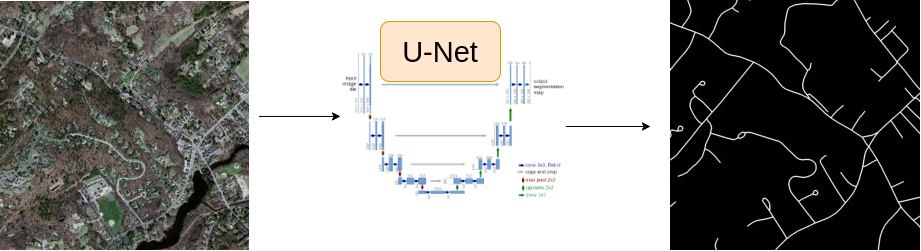

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_File = "/content/Road_seg_dataset/train.csv"
Data_Dir = "/content/Road_seg_dataset/"

Device = 'cuda'

Epochs = 15
Lr = 0.003
Batch_Size =8

Image_Size = 512

Encoder = 'timm-efficientnet-b0'
Weights = 'imagenet'



In [ ]:
df = pd.read_csv(CSV_File)
df

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png
...,...,...
194,images/18178735_15.png,masks/18178735_15.png
195,images/24178480_15.png,masks/24178480_15.png
196,images/24629305_15.png,masks/24629305_15.png
197,images/23728495_15.png,masks/23728495_15.png


In [ ]:
idx = 2
row =df.iloc[idx]
image_path = Data_Dir + row.images
mask_path= Data_Dir + row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255

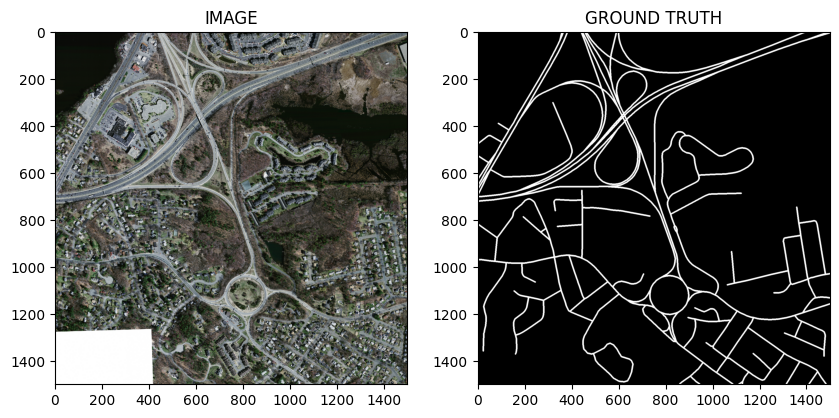

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20,random_state=42)
print(len(train_df))
len(valid_df)

159


40

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(Image_Size , Image_Size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
def get_Valid_augs():
  return A.Compose([
      A.Resize(Image_Size , Image_Size)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = df.iloc[idx]
    image_path = Data_Dir + row.images
    mask_path = Data_Dir + row.masks

    image =cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w)
    mask = np.expand_dims(mask, axis = -1) #( Height ,width ,channel)

    if A.augmentations:
      data =self.augmentations(image=image, mask = mask)
      image = data['image'] # (h,w, c)
      mask = data['mask']
    image = np.transpose(image,(2,0,1)).astype(np.float32) # (C,H,W)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32) # (C,H,W)

    image = torch.Tensor(image) / 255.0
    mask =  torch.round(torch.Tensor(mask)/ 255.0)

    return image, mask




In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_Valid_augs())

In [ ]:
print(f'Size of trainset: {len(trainset)}')
print(f'Size of Validset: {len(validset)}')


Size of trainset: 159
Size of Validset: 40


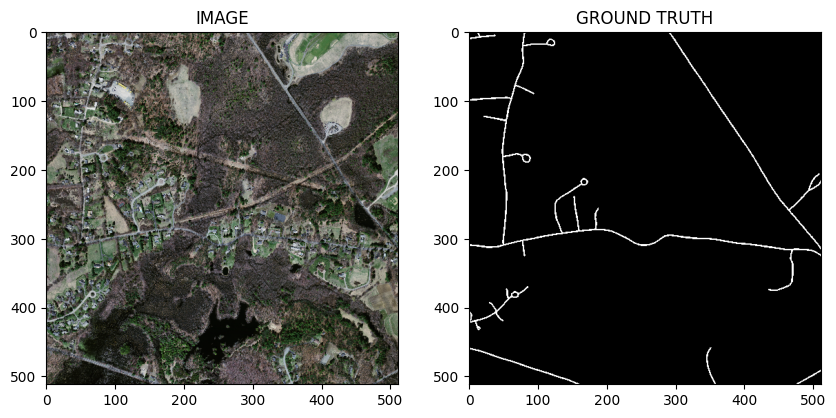

In [ ]:
idx = 32

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader


In [ ]:
trainloader = DataLoader(trainset, batch_size=Batch_Size,shuffle=True)
validloader = DataLoader(validset,batch_size=Batch_Size)

In [ ]:
print(f'TOtal No. of Batches in Trainloader:{len(trainloader)}')
print(f'TOtal No. of Batches in Validloader:{len(validloader)}')

TOtal No. of Batches in Trainloader:20
TOtal No. of Batches in Validloader:5


In [ ]:
for images ,masks in trainloader:
  print(f" One batch image shape : {image.shape}")
  print(f" One batch mask shape : {mask.shape}")
  break;

 One batch image shape : torch.Size([3, 512, 512])
 One batch mask shape : torch.Size([1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = Encoder,
        encoder_weights = Weights,
        in_channels = 3,
        classes = 1,
        activation= None
    )

  def forward(self, images, masks = None):

    logits =self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = "binary")(logits ,masks) + nn.BCEWithLogitsLoss()(logits,masks)

    return logits

In [ ]:
model = SegmentationModel()
model.to(Device)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): S

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(dataloader,model,optimizer):
  model.train()

  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(Device)
    masks = masks.to(Device)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+= loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader,model):
  model.eval()

  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(Device)
      masks = masks.to(Device)
      logits, loss = model(images,masks)
      total_loss+= loss.item()

  return total_loss / len(dataloader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr= Lr)

In [ ]:
best_loss=np.inf

for epoch in range(Epochs):
  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(validloader,model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-seg-model.pt")
    print("Saved-model")
    best_loss= valid_loss

  print(f"Epochs:{epoch +1 } Train Loss: {train_loss} Valid Loss : { valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Saved-model
Epochs:1 Train Loss: 1.127286297082901 Valid Loss : 1.0213256359100342


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Saved-model
Epochs:2 Train Loss: 0.7970086455345153 Valid Loss : 0.7641821026802063


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Saved-model
Epochs:3 Train Loss: 0.7259086698293686 Valid Loss : 0.7406559705734252


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Saved-model
Epochs:4 Train Loss: 0.7154678881168366 Valid Loss : 0.6954866170883178


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Saved-model
Epochs:5 Train Loss: 0.6852548718452454 Valid Loss : 0.6549096703529358


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epochs:6 Train Loss: 0.6636721700429916 Valid Loss : 0.6672808349132537


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Saved-model
Epochs:7 Train Loss: 0.665503990650177 Valid Loss : 0.6453359723091125


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epochs:8 Train Loss: 0.6515333682298661 Valid Loss : 0.7118299126625061


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epochs:9 Train Loss: 0.6308904945850372 Valid Loss : 0.6469887614250183


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epochs:10 Train Loss: 0.6307801991701126 Valid Loss : 0.6655592083930969


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Saved-model
Epochs:11 Train Loss: 0.6270491749048233 Valid Loss : 0.5929920256137848


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epochs:12 Train Loss: 0.6269212126731872 Valid Loss : 0.6393838286399841


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Saved-model
Epochs:13 Train Loss: 0.6082727462053299 Valid Loss : 0.5794447660446167


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epochs:14 Train Loss: 0.6119338572025299 Valid Loss : 0.6235115170478821


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

Epochs:15 Train Loss: 0.6102202415466309 Valid Loss : 0.6106680750846862


# Task 9 : Inference

In [ ]:
idx =31
model.load_state_dict(torch.load("/content/best-seg-model.pt"))
image, mask = validset[idx]

logits_mask = model(image.to(Device).unsqueeze(0)) #(c,h,w )-> (b,c,h,w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0


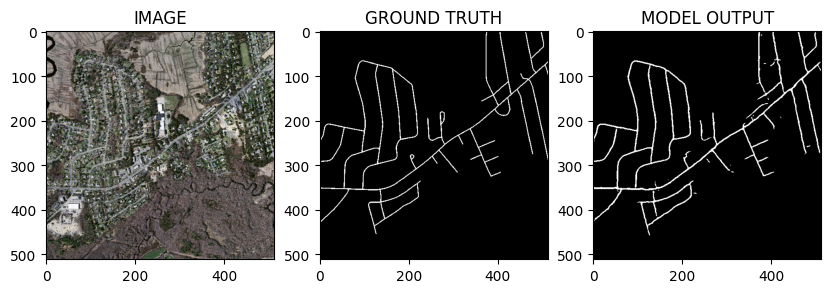

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))